# <center>CIFAR10 - Image Classification with Tensorflow & Keras</center>
<br/><center><img src="files/keras-tensorflow-logo.jpg"></center>


## Part-1 - Creating the base model with Keras

In this series, we will illustrate multi-class image classification for the CIFAR10 dataset using Convolution Neural Networks (CNNs). The CIFAR-10 dataset consists of 60,000 32x32 colour images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images. Output classes defined are `['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog'. 'horse', 'ship', 'truck']`. You can download the image set for Python from [this link](https://www.cs.toronto.edu/~kriz/cifar.html). However, the Keras library already includes this dataset and I am going to load it from there.  

A good model/network, is one that generalizes well (i.e. performs well on data that it has not seen during training). With CNNs, indeed any deep network, the main problem is overfitting (and hence poor generalization). For a given network/model architecture, we can address overfitting my using regularization & increasing the size of the training data.

We will develop a progressively improving model with the following steps:
1. In **Part-1**: We'll develop a base-model. You'll notice that this model overfits and does not generalize well (i.e. accuracy score on test/validation data is poor compared to training data).
2. In **Part-2**: We'll add regularization (- we'll use L2 regularization &amp; dropout regularization) and batch normalization. You'll see that this improves the model's generalization somewhat.
3. In **Part-3**: We'll increase training data size artifically - we'll use image augmentation techniques to create an infinite stream of image batches with random transformations applied to each batch. You'll notice that adding image augmentation improves the model generalization further. We'll use Keras' `ImageDataGenerator()`class [see API](https://keras.io/preprocessing/image/#imagedatagenerator-class) for the same.

Each part has 2 associated IPython notebooks - one with the Keras code and the other with the Tensorflow code. 

**This is Part-1 (Keras Version), where we develop the base model** - you can jump directly to the [Tensorflow version](CIFAR10%20-%20Multiclass%20Classification%20-%20CNN%20-%20Tensorflow%20%26%20Keras-Part-1-Tensorflow.ipynb) if you prefer Tensorflow.

This workbook is divided into 4 broad sections:
+ [Helper functions](#helper_functions)
+ [Loading & Preprocessing Data](#loading_and_preprocessing)
+ [Building & Running our Keras Model](#building_and_running_model)
+ [Predictions](#predictions)

<font color='scarlet'> It is best to run these workbooks on a machine with a GPU - I have run these on a _modest_ configuration (i5 CPU, Win10-64bit or Ubuntu 16.04-64bit, 8GB RAM, 2GB Nvidia GPU). I have also run these on a CPU-only machine, where the models took very long to train.</font>

In [1]:
# imports & tweaks
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys, time

plt.style.use('seaborn-colorblind')
plt.rcParams['figure.figsize'] = (8,6)
sns.set_style('darkgrid')
sns.set_context('talk')
sns.set_style({'font.sans-serif':['Verdana','Arial','Calibri','DejaVu Sans']})
%matplotlib inline

# you must always seed all random number generators to get same results every run
# Any seed value will do
seed = 123
np.random.seed(seed)

### Helper Functions: <a name="helper_functions"/>

In [2]:
# a utility function that plots the losses and accuracies for training & validation sets across our epochs
def show_plots(history):
    """ Useful function to view plot of loss values & accuracies across the various epochs """
    loss_vals = history['loss']
    val_loss_vals = history['val_loss']
    epochs = range(1, len(history['acc'])+1)
    
    f, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,4))
    
    # plot losses on ax[0]
    ax[0].plot(epochs, loss_vals, color='navy',marker='o', linestyle=' ', label='Training Loss')
    ax[0].plot(epochs, val_loss_vals, color='firebrick', marker='*', label='Validation Loss')
    ax[0].set_title('Training & Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend(loc='best')
    ax[0].grid(True)
    
    # plot accuracies
    acc_vals = history['acc']
    val_acc_vals = history['val_acc']

    ax[1].plot(epochs, acc_vals, color='navy', marker='o', ls=' ', label='Training Accuracy')
    ax[1].plot(epochs, val_acc_vals, color='firebrick', marker='*', label='Validation Accuracy')
    ax[1].set_title('Training & Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend(loc='best')
    ax[1].grid(True)
    
    plt.show()
    plt.close()
    
    # delete locals from heap before exiting
    del loss_vals, val_loss_vals, epochs, acc_vals, val_acc_vals

In [3]:
def print_time_taken(start_time, end_time):
    secs_elapsed = end_time - start_time
    
    SECS_PER_MIN = 60
    SECS_PER_HR  = 60 * SECS_PER_MIN
    
    hrs_elapsed, secs_elapsed = divmod(secs_elapsed, SECS_PER_HR)
    mins_elapsed, secs_elapsed = divmod(secs_elapsed, SECS_PER_MIN)
    
    if hrs_elapsed > 0:
        print('Time taken: %d hrs %d mins %d secs' % (hrs_elapsed, mins_elapsed, secs_elapsed))
    elif mins_elapsed > 0:
        print('Time taken: %d mins %d secs' % (mins_elapsed, secs_elapsed))
    elif secs_elapsed > 1:
        print('Time taken: %d secs' % (secs_elapsed))
    else:
        print('Time taken - less than 1 sec')

### Loading & Preprocessing Data <a name="loading_and_preprocessing"/>

I am going to load the CIFAR-10 dataset from the `keras.datasets` library using the `karas.datasets.cifar10.load_data()` call. This will download data from the cs.toronto.edu website the very first time you run it. The function conveniently returns two tuples - on for training data & labels and the other for test data & labels. The images are shaped correctly as (num_samples, 32, 32, 3) & labels (num_samples, 1). However, the images not normalized and labels are not one-hot-encoded, which is something we will do.

In [4]:
from keras.datasets.cifar10 import load_data
from keras.utils import to_categorical

Using TensorFlow backend.


In [5]:
(train_data, train_labels), (test_data, test_labels) = load_data()
train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

Notice that we have 50,000 images in the training set & 10,000 images in the test set. We have 10 catrgories of output labels as below.

Label Values & Descriptions: 
* 0 - Airplane
* 1 - Automobile
* 2 - Bird
* 3 - Cat 
* 4 - Deer 
* 5 - Dog 
* 6 - Frog 
* 7 - Horse 
* 8 - Ship 
* 9 - Truck

Let us view how some of the images look - we will randomly pick 20 images from the `train_data` set. First, let us create a Python `dict` that will help us decode the label values to human readable text.

In [6]:
# need to look at labels again
cifar10_labels = {
    0 : 'Airplane', 
    1 : 'Automobile', 
    2 : 'Bird', 
    3 : 'Cat', 
    4 : 'Deer', 
    5 : 'Dog', 
    6 : 'Frog', 
    7 : 'Horse', 
    8 : 'Ship', 
    9 : 'Truck'    
}

In [7]:
rand_20 = np.random.randint(0, train_data.shape[0],20)
sample_data = train_data[rand_20]
sample_labels = train_labels[rand_20].ravel()

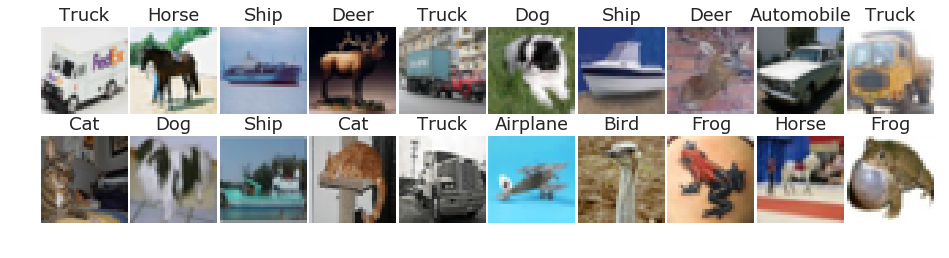

In [8]:
row_count, col_count = 2, 10
f, ax = plt.subplots(row_count, col_count, figsize=(16,4), gridspec_kw={'wspace':0.03, 'hspace':0.01}, squeeze=True)
for r in range(row_count):
    for c in range(col_count):
        image_index = r * col_count + c
        ax[r,c].axis("off")
        ax[r,c].imshow(sample_data[image_index])
        ax[r,c].set_title(cifar10_labels[sample_labels[image_index]])
plt.show()
plt.close()

**Data Pre-processing:** We need to pre-process our image & labels data before feeding it to our CNN.
* As the `load_data()` function has already returned the image & labels data in the correct shapes viz. training data -> Image shape: `(50000, 32, 32, 3)`, labels shape: `(50000,1)`; test data -> Image shape: `(10000, 32, 32, 3)`, labels shape: `(10000,1)`, **we don't need to reshape our image & label arrays**.
* However, **the image data needs to be re-scaled** - we will convert image date to `float` type & divide by `255.0`, so all pixels have values between `0.0` & `1.0`.
* Finally, **the image labels need to be one-hot-encoded** (as we have 10 classes) - we will use Keras' `to_categorical()` function to help us with this.

In [9]:
# some globals for later use
image_height, image_width = train_data.shape[1], train_data.shape[2]
num_channels = 3  # as we have color images
num_classes = 10  # 10 output classes
input_shape = image_height * image_width * num_channels
image_height, image_width, num_channels, num_classes, input_shape

(32, 32, 3, 10, 3072)

In [10]:
# # normalize the images - between 0.0 & 1.0
# train_data = train_data.astype('float32') / 255.
# test_data = test_data.astype('float32') / 255.

# mean normalize the data (i.e. z-scores)
train_data = train_data.astype('float32')
test_data = test_data.astype('float32')

# mean normalize the images by calculating the mean & stdev of the test images
# along all 4 axes and then finding the z-scores for train & test images using 
# these values.

mean = np.mean(train_data,axis=(0,1,2,3))
std = np.std(train_data,axis=(0,1,2,3))
train_data = (train_data-mean)/(std)
test_data = (test_data-mean)/(std)

In [11]:
# one-hot-encode the labels - so 3 becomes [0 0 0 1 0 0 0 0 0 0] & so on...
train_labels_cat = to_categorical(train_labels,num_classes)
test_labels_cat = to_categorical(test_labels,num_classes)
train_labels_cat.shape, test_labels_cat.shape

((50000, 10), (10000, 10))

In [12]:
train_data.shape, train_labels_cat.shape, test_data.shape, test_labels_cat.shape

((50000, 32, 32, 3), (50000, 10), (10000, 32, 32, 3), (10000, 10))

Perfect!

Here is how we will train & test our model:
* Create training & validation sets (from training data)
    * Shuffle the training data & labels, so as to rid it of any sort of ordering it may have (not required for test data!).
    * Set aside 10% of the _training_ data & labels as _validation_ set - since we have shuffled the training data, we could choose the first 10% of records as the validation set & the rest as the training set.
* Our CNN will be trained _strictly_ on the training data _only_ & _cross-validated_ on the validation set. For training, we will put the model through `15` epochs and use batch gradient descent, with a batch-size of `100`. These are somewhat arbitrary choices.
* As the model trains, we will calculate the loss & accuracies per epoch on the training & validation sets - these will then be plotted (loss vs epochs and accuracies vs epochs) to assess how our model is bahaving.
* Finally we will test the model with test data, which the model has _never seen_ during training.

As good test score will mean that the model is generalizing well. A poor score means that it needs improvement.

**NOTE:** for a complex problem, like classification of colored images, we don't really have sufficient training data. So at the very outset, I am expecting _poor_ test scores!

In [13]:
# shuffle the training dataset & set aside val_perc % of rows as validation data
for _ in range(5): 
    indexes = np.random.permutation(len(train_data))

# randomly sorted!
train_data = train_data[indexes]
train_labels_cat = train_labels_cat[indexes]

# now we will set-aside val_perc% of the train_data/labels as cross-validation sets
val_perc = 0.10
val_count = int(val_perc * len(train_data))

# first pick validation set
val_data = train_data[:val_count,:]
val_labels_cat = train_labels_cat[:val_count,:]

# leave rest in training set
train_data2 = train_data[val_count:,:]
train_labels_cat2 = train_labels_cat[val_count:,:]

train_data2.shape, train_labels_cat2.shape, val_data.shape, val_labels_cat.shape, test_data.shape, test_labels.shape

((45000, 32, 32, 3),
 (45000, 10),
 (5000, 32, 32, 3),
 (5000, 10),
 (10000, 32, 32, 3),
 (10000, 1))

In [14]:
# some more globals...
num_features = train_data.shape[1]
# num_epochs = 15
# batch_size = 100
# ksize = 3
# psize = 2
# strides = 1

### Building & Running our Keras Model <a name="building_and_running_model"/>

In this section we will create the base model with Keras' _Sequential API_ and train it against our train/validation sets. We use the following config:
* **2** `Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='elu')` layers, followed by a `MaxPooling2D(pool_size=2)` layer. The first `Conv2D(...)` layer will have the `input_shape=(32,32,3)` parameter, defining the shape of our training data.
* **2** `Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='elu')` layers, followed by a `MaxPooling2D(pool_size=2)` layer. 
* **2** `Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='elu')` layers, followed by a `MaxPooling2D(pool_size=2)` layer. 
* **NOTE**: After 3 MaxPooling2D layers, we end up with a 4 x 4 image.
* **1** `Flatten()` layer, which will flatten out the output of the previous `Conv2D() + MaxPooling2D()` layers.
* **1** `Dense(512, activation='relu')` layer
* **Output layer** `Dense(10, activation='softmax')` - we use `softmax` activation function for a multi-class classification problem.
* We will use the `RMSProp optimizer` with `learning rate = 0.001`, the `categorical_crossentropy` loss and measure `accuracy` metric as we train

In [15]:
from keras.models import Sequential
from keras.layers import Dense, MaxPooling2D, Conv2D, Flatten

In [16]:
def build_keras_model():
    model = Sequential()
  # CNN layers
    model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='elu',
                     input_shape=(image_height, image_width, num_channels)))
    model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='elu'))
    model.add(MaxPooling2D(pool_size=2))
    
    model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='elu'))
    model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='elu'))  
    model.add(MaxPooling2D(pool_size=2))                  

    model.add(Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='elu'))
    model.add(Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='elu'))              
    model.add(MaxPooling2D(pool_size=2))                   

  # Flatten
    model.add(Flatten())
  # Dense (fully connected) layers
    model.add(Dense(512, activation='relu')) 
  # output layer with softmax
    model.add(Dense(10, activation='softmax'))
  # compile with categorical_crossentropy loss function & adam optimizer
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [17]:
kr_base_model = build_keras_model()
print(kr_base_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)         73856     
__________

In [18]:
# train the model

start_time = time.time()

kr_history = kr_base_model.fit(train_data2, train_labels_cat2, epochs=15, batch_size=100,
                               validation_data=(val_data,val_labels_cat))

end_time = time.time()
print_time_taken(start_time, end_time)

Train on 45000 samples, validate on 5000 samples
Epoch 1/15
45000/45000 [==============================] - 383s 9ms/step - loss: 1.3519 - acc: 0.5275 - val_loss: 0.9236 - val_acc: 0.6762
Epoch 2/15
45000/45000 [==============================] - 364s 8ms/step - loss: 0.8212 - acc: 0.7159 - val_loss: 0.8090 - val_acc: 0.7284
Epoch 3/15
45000/45000 [==============================] - 396s 9ms/step - loss: 0.5974 - acc: 0.7950 - val_loss: 0.7671 - val_acc: 0.7416
Epoch 4/15
45000/45000 [==============================] - 382s 8ms/step - loss: 0.4277 - acc: 0.8539 - val_loss: 0.9704 - val_acc: 0.7362
Epoch 5/15
45000/45000 [==============================] - 360s 8ms/step - loss: 0.3135 - acc: 0.8935 - val_loss: 0.9892 - val_acc: 0.7640
Epoch 6/15
45000/45000 [==============================] - 350s 8ms/step - loss: 0.2380 - acc: 0.9210 - val_loss: 1.0707 - val_acc: 0.7392
Epoch 7/15
45000/45000 [==============================] - 344s 8ms/step - loss: 0.2102 - acc: 0.9324 - val_loss: 1.2421 - v

**Observation & Interpretation:** 
* The base Keras model achieves a **training accuracy of ~96%**, but it gets **around 75% on the validation accuracy** - see `acc` and `val_acc` columns in the output above. 
* This is the behavior of an overfitting model - hight accuracy on training data, but much lower accuracy on valudation data. 
* We could run the model through more epochs, which may improve the training accuracy, but NOT the validation accuracy, which is what we need to improve!

Let's plot the test & validation losses vs epochs and test & validation accuracies vs epochs. We'll use the `show_plots()` function coded above, which plots out neat graphs in a 1 x 2 grid.. You need to pass the `history` attribute of the return value from the Keras call (see call below).

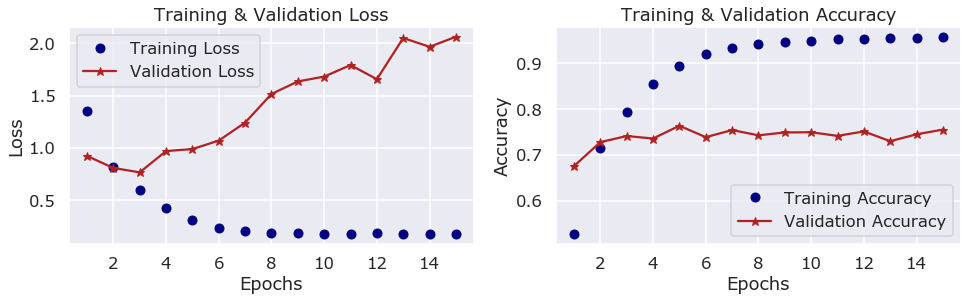

In [19]:
show_plots(kr_history.history) 

**Observations from graphs:** There you go. A tell-tale behavior of an overfitting model.
+ On the top-left we are plotting training & validation loss vs epochs - we can see that the training loss falls smoothly towards zero. However the validation loss falls (though not smoothly) for a few epochs (~5) and then rises(!).
+ On the top-right we are plotting the training & validation accuracies vs epochs - we can see that the training accuracy rises across epochs and approachs 1. However, the validation accuracy flattens out after a few epochs (~5) - it appears to be flattening around 75%.
+ This means that the model has started overfitting our training images after ~5-6 epochs. Training for more epochs is not going to improve _validation accuracy_.

**Next, and very important, let us see how our model performs against test data** - recall that the model has not seen this data before (during the entire training process). Considering that the model fared poorly on validation data, I don't expect a good test accuracy score - it should be around 74%, the same value around which the validation accuracy curve started to flatten out at. Let's call the `evaluate()` function on the Keras model, passing in test data & labels - this functions does a batch run on training data for 1 epoch & reports the loss & accuracy as a tuple.

In [20]:
test_loss, test_accuracy = kr_base_model.evaluate(test_data, test_labels_cat, batch_size=100)
print('Test loss: %8.4f accuracy: %.3f' % (test_loss, test_accuracy))

10000/10000 [==============================] - 34s 3ms/step
Test loss:   2.0598 accuracy: 0.752


**Observations:**
* As expected, the test accuracy is ~74%, which means that our model has not generalized well at all.
* This is to be expected as we do not have enough images to train such a complex model. Typically, we'll need several thousand more images to train a complex model, like the one we have used. 

Let's run some preductions on the model & see how it fares - again, I expect a lot of errors. We'll randomly pick 20 images from the test dataset & predict the outcomes & compare them to the actuals. We'll also predict the probabilities of each output class & view the top 3 predictions that our model came up with.

### Predictions <a name="predictions"/>

In [21]:
# let's pick 20 random values from the test data
rand_idx = np.random.randint(0, test_data.shape[0],20)
rand_images = test_data[rand_idx]
rand_labels_true = test_labels_cat[rand_idx]

In [22]:
# one-hot-decode the labels (reverse on-hot encoding)
y_true = np.argmax(rand_labels_true, axis=1)
y_true

array([6, 4, 2, 1, 2, 6, 9, 8, 2, 8, 0, 1, 9, 0, 1, 4, 2, 3, 0, 9])

In [23]:
# predictions
y_pred = np.argmax(kr_base_model.predict(rand_images), axis=1)
y_pred

array([4, 4, 2, 1, 2, 6, 9, 8, 2, 8, 0, 1, 0, 0, 1, 3, 2, 3, 0, 9])

Quickly eye-balling the above results, we can see quite a few incorrect predictions. Next, let's examine the top 3 predictions of our model.

In [24]:
def show_predictions(model, data, one_hot_labels, label_names=None, top_n=3):
    
    """ for every row in the data/labels set, it shows the actual label, predicted label and the 
        top_n predictions of the model """
    def decode_topn(pred_pairs, label_names, top_n):
        #[(6, 4, [(4, 0.99946624), (3, 0.00046321715), (6, 6.602875e-05)])
        assert len(pred_pairs) == top_n
        result = ''
        for i in range(top_n):
            result += '(%d%s:%.5f) ' % (pred_pairs[i][0], 
                                (' [' + label_names[pred_pairs[i][0]] + ']' if label_names is not None else ''),
                                 pred_pairs[i][1])
        return result    
        
    y_true = np.argmax(one_hot_labels, axis=1)
    pred_probas = model.predict(data)
    y_pred = np.argmax(pred_probas, axis=1)
    
    results = []
    
    for i, _ in enumerate(y_true):
        true_class_i = y_true[i]
        pred_class_i = y_pred[i]
        # for the ith prediction
        pred_pairs_i = [(cls, pred_probas[i][cls]) for cls, _ in enumerate(pred_probas[i])]
        pred_pairs_i = sorted(pred_pairs_i, key=lambda t: t[1], reverse=True)
        results.append((true_class_i, pred_class_i, pred_pairs_i[:top_n]))
                       
    # above block will return a list, with each entry as below
    # [(true_class_0, pred_class_0,[(4,0.98),(2,0.36),(0,0.15)]),
    #  (true_class_1, pred_class_1, [(6,0.65),(0,0.45),(1,0.23)]),...]

    assert len(results) == len(y_true)
    # return results
                              
    # display formatted results
    predictions = []
    for i in range(len(y_true)):
        #print(decode_topn(results[i][2]))
        # return a list of tuples - one tuple for each row in data, each tuple as follows:
        # (Actual Code, Actual Class Decoded, Predicted Code, Predicted Class Decoded, Top_N_predictions tuple)
        # Top_N_predictions tuple = ()
        print('A: %d%s P: %d%s Top:%s' % \
               (results[i][0], (' (' + label_names[results[i][0]] + ')' if label_names is not None else ''),
                results[i][1], (' (' + label_names[results[i][1]] + ')' if label_names is not None else ''),
                decode_topn(results[i][2], label_names, top_n))
             )

In [25]:
show_predictions(kr_base_model, rand_images, rand_labels_true, cifar10_labels, 3)

A: 6 (Frog) P: 4 (Deer) Top:(4 [Deer]:0.99991) (6 [Frog]:0.00006) (7 [Horse]:0.00003) 
A: 4 (Deer) P: 4 (Deer) Top:(4 [Deer]:1.00000) (6 [Frog]:0.00000) (2 [Bird]:0.00000) 
A: 2 (Bird) P: 2 (Bird) Top:(2 [Bird]:0.99999) (3 [Cat]:0.00001) (5 [Dog]:0.00000) 
A: 1 (Automobile) P: 1 (Automobile) Top:(1 [Automobile]:1.00000) (9 [Truck]:0.00000) (8 [Ship]:0.00000) 
A: 2 (Bird) P: 2 (Bird) Top:(2 [Bird]:0.99976) (7 [Horse]:0.00013) (3 [Cat]:0.00011) 
A: 6 (Frog) P: 6 (Frog) Top:(6 [Frog]:1.00000) (2 [Bird]:0.00000) (4 [Deer]:0.00000) 
A: 9 (Truck) P: 9 (Truck) Top:(9 [Truck]:1.00000) (0 [Airplane]:0.00000) (8 [Ship]:0.00000) 
A: 8 (Ship) P: 8 (Ship) Top:(8 [Ship]:0.99997) (0 [Airplane]:0.00002) (9 [Truck]:0.00001) 
A: 2 (Bird) P: 2 (Bird) Top:(2 [Bird]:1.00000) (3 [Cat]:0.00000) (4 [Deer]:0.00000) 
A: 8 (Ship) P: 8 (Ship) Top:(8 [Ship]:0.99997) (0 [Airplane]:0.00003) (1 [Automobile]:0.00000) 
A: 0 (Airplane) P: 0 (Airplane) Top:(0 [Airplane]:1.00000) (2 [Bird]:0.00000) (3 [Cat]:0.00000) 
A: 1

In [26]:
def save_model(model, base_file_name):
    # save the structure to JSON & weights to HD5
    # serialize model to JSON
    model_json = model.to_json()
    file_1, file_2 = base_file_name + ".json", base_file_name + ".h5"
    with open(file_1, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(file_2)
    print("Saved model to files %s and %s" % (file_1, file_2))

In [27]:
# let's save our model
#kr_base_model.save('cifar10_part1_keras.h5')
save_model(kr_base_model, 'cifar10_part1_keras')

Saved model to files cifar10_part1_keras.json and cifar10_part1_keras.h5


## Summary:
* In this workbook we created a base model with Keras, which we trained on `45,000` images for `15` epochs.
* We observed that the model was overfitting the training data after `~6` epochs, when the validation loss started to flatten off after falling towards zero and the validation accuracy started to flatten after rising. 
* Our model achieved a final _training accuracy_ `~95%` and _validation accuracy_ `74%`, which was indicative of an overfitting model.
* The low _test accuracy_ `~74%` + large difference between training & validation accuracies confirms overfitting.
* For the same reason, a lot of our predictions were off from the actual values.

This behavior was expected - we simply do not have enough images to train our model so that it generalizes well. 

In Part-2 we will add regularization - using L2 regularization and dropout techniques and batch normalization to further improve the generalization of the base model.

#### A Note on my Setup:
I am using the following tools for running these workbooks:
* Python 3.6.6 (64 bit) on Windows 10 (64 bit) / Ubuntu 16.04 (64 bit)
* Numpy 1.14 or greater
* Matplotlib 2.2 or later
* Seaborn 0.9.0 or later
* Tensorflow 1.8.0 (GPU version)
* Keras 2.2.0 (GPU version)

## <center>-*- END -*- </center>